Libraries used

In [2]:
# from google.colab import drive
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.measure import EllipseModel
from scipy.optimize import least_squares

Drive acess to use Data

In [3]:
# drive.mount('/content/drive')

csv understanding

*   0--> Shape
*   1--> Direction
*   2-->x axis
*   2-->y axis

In [4]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs
a=read_csv('Test Dataset/isolated.csv')


print(len(a)) ## all 3 shapes
print(len(a[0])) ##circle
print(len(a[0][0])) ## repesesnting circle
print(len(a[0][0][0])) ## representing x,y coords

3
1
419
2


Plotting whole drawing


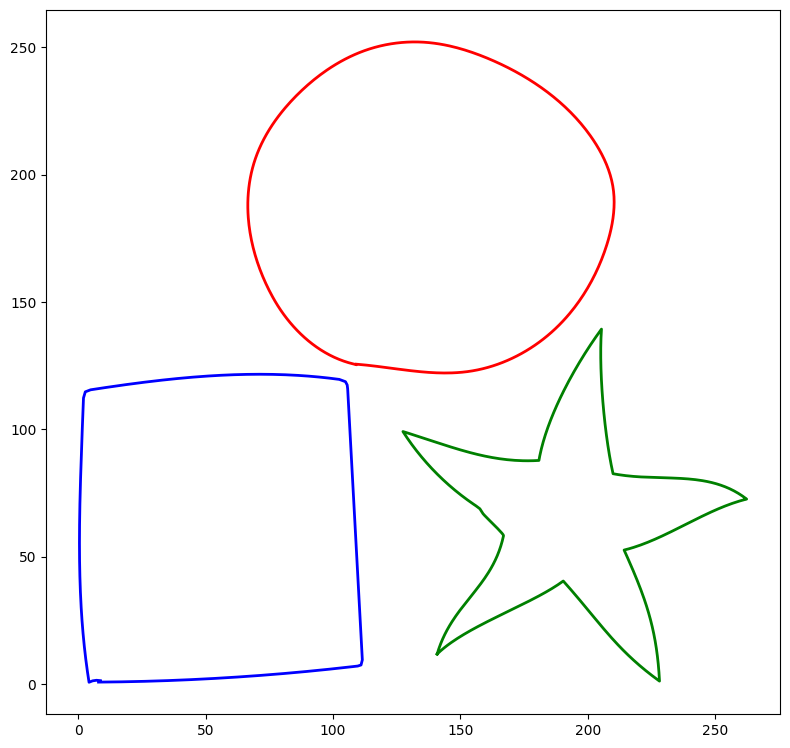

In [5]:


def plot(paths_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]

        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()

plot(a, ['r', 'g', 'b', 'y'])

plotting individual drawing


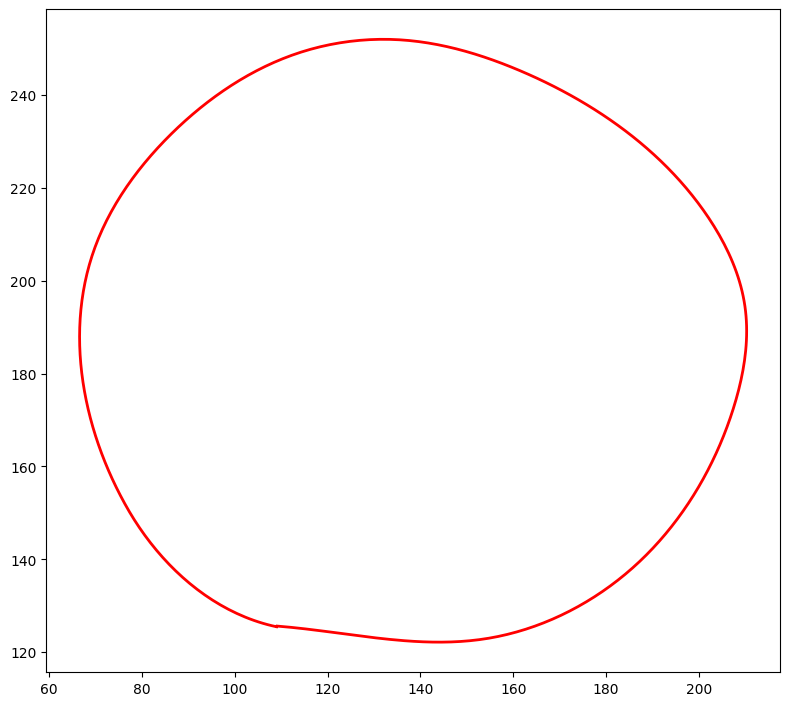

None


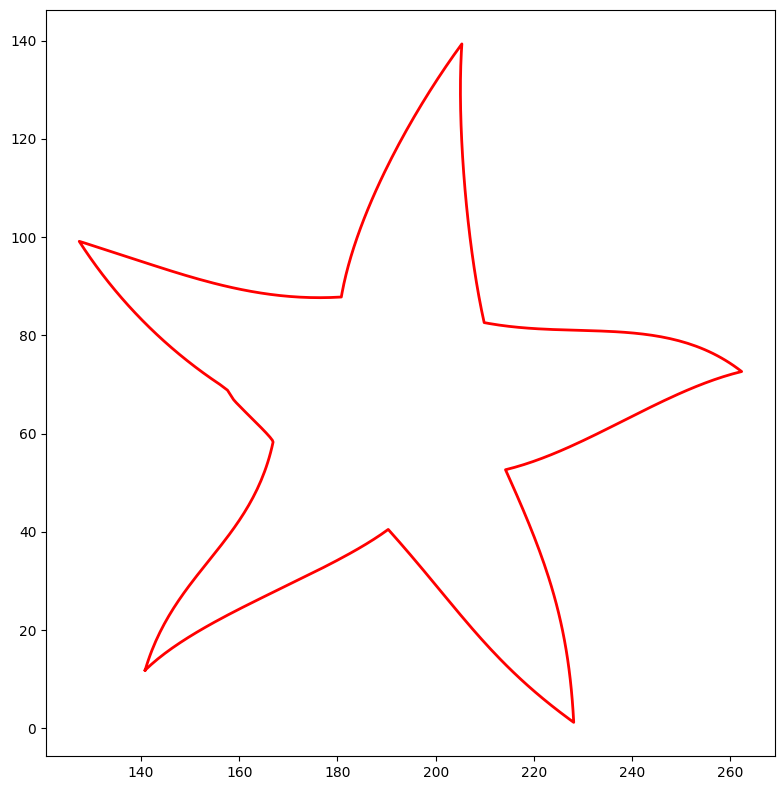

None


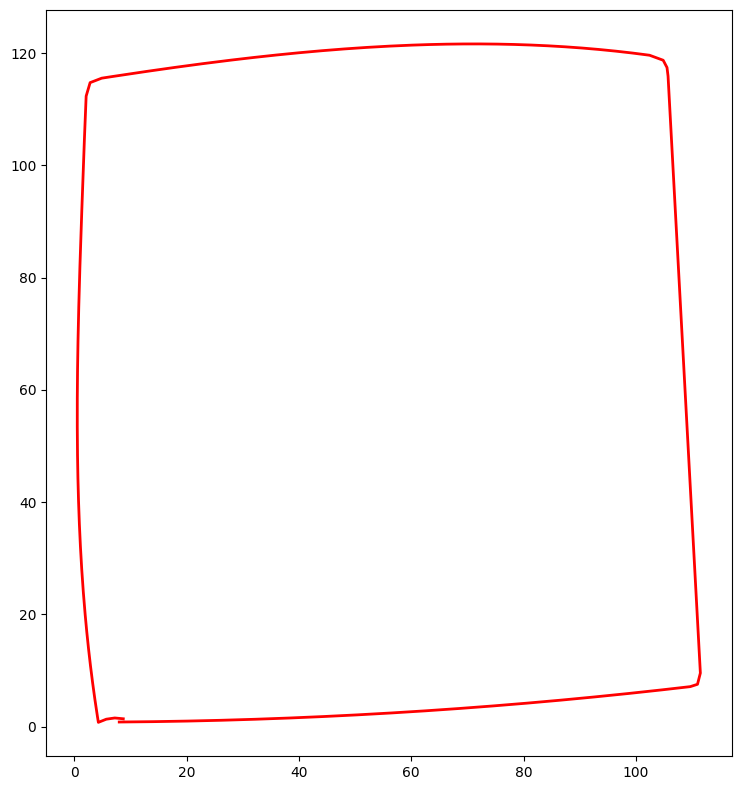

None


In [6]:
def plot_shape(paths_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]

        ax.plot(XYs[:, 0], XYs[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()
print(plot_shape(a[0], ['r', 'g', 'b', 'y']))
print(plot_shape(a[1], ['r', 'g', 'b', 'y']))
print(plot_shape(a[2], ['r', 'g', 'b', 'y']))

Get Endpoints of the both end draw straight line from it


In [7]:
def regularize_line(points):
    p1, p2 = points[0], points[-1]
    x = np.array([p1[0], p2[0]])
    y = np.array([p1[1], p2[1]])

    return np.column_stack((x, y))


Fit an ellipse to the given points using a model.
Generate parameterized points around the ellipse using angles spaced evenly between
0 and
2
2π.
Compute the coordinates of the ellipse based on its center, axes, and rotation.



1.  a * np.cos(theta_values) * np.cos(theta): Projects the semi-major axis onto the x-axis.

2.  b * np.sin(theta_values) * np.sin(theta): Projects the semi-minor axis onto the x-axis.

3. a * np.cos(theta_values) * np.sin(theta): Projects the semi-major axis onto the y-axis.

4. b * np.sin(theta_values) * np.cos(theta): Projects the semi-minor axis onto the y-axis.




In [8]:
def regularize_ellipse(points):
    if len(points) < 5:
        return np.array([])

    ellipse = EllipseModel()
    ellipse.estimate(points)
    xc, yc, a, b, theta = ellipse.params

    num_points = len(points)
    theta_values = np.linspace(0, 2 * np.pi, num_points)
    x = xc + a * np.cos(theta_values) * np.cos(theta) - b * np.sin(theta_values) * np.sin(theta)
    y = yc + a * np.cos(theta_values) * np.sin(theta) + b * np.sin(theta_values) * np.cos(theta)

    return np.column_stack((x, y))

determines the circle's center as the average of the input points and estimates the radius as the median distance from the center to these points.

In [9]:
def regularize_circle(points, max_width, max_height, scale_factor=0.9):
    center = np.mean(points, axis=0)
    radius = np.median(np.linalg.norm(points - center, axis=1))

    min_dimension = min(max_width, max_height)
    scale = (min_dimension * scale_factor) / (2 * radius)

    num_points = len(points)
    theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    x = center[0] + radius * scale * np.cos(theta)
    y = center[1] + radius * scale * np.sin(theta)

    return np.column_stack((x, y))

standardizes a set of points into a rectangle by first determining the bounding box of the input points. It calculates the width and height of this bounding box and then scales these dimensions to fit within given max_width and max_height constraints, applying a scale_factor for adjustment

In [10]:
def regularize_rectangle(points, max_width, max_height, scale_factor=0.9):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]

    scale_x = (max_width * scale_factor) / width
    scale_y = (max_height * scale_factor) / height

    center = np.mean(points, axis=0)

    x = [min_coords[0], max_coords[0], max_coords[0], min_coords[0], min_coords[0]]
    y = [min_coords[1], min_coords[1], max_coords[1], max_coords[1], min_coords[1]]

    x = center[0] + (np.array(x) - center[0]) * scale_x
    y = center[1] + (np.array(y) - center[1]) * scale_y

    return np.column_stack((x, y))

In [11]:
def regularize_rounded_rectangle(points):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]

    corner_radius = min(width, height) * 0.1

    corners = [
        [min_coords[0] + corner_radius, min_coords[1] + corner_radius],
        [max_coords[0] - corner_radius, min_coords[1] + corner_radius],
        [max_coords[0] - corner_radius, max_coords[1] - corner_radius],
        [min_coords[0] + corner_radius, max_coords[1] - corner_radius]
    ]

    x = [p[0] for p in corners] + [corners[0][0]]
    y = [p[1] for p in corners] + [corners[0][1]]

    return np.column_stack((x, y))


It computes the center of the points and estimates the maximum radius as the furthest distance from this center. The function then defines a star pattern with alternating radii: the maximum radius and a smaller radius set to 40% of the maximum. By creating vertices at these alternating radii and angles, it forms a star shape with 10 points. Finally, it closes the shape by appending the initial vertex and returns the coordinates of the star.




In [12]:
def regularize_star(points):
    center = np.mean(points, axis=0)
    max_radius = np.max(np.linalg.norm(points - center, axis=1))
    min_radius = max_radius * 0.4

    num_points = 10
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    radii = np.zeros(num_points)
    radii[::2] = max_radius
    radii[1::2] = min_radius

    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)

    x = np.append(x, x[0])
    y = np.append(y, y[0])

    return np.column_stack((x, y))


The rdp function implements the Ramer-Douglas-Peucker (RDP) algorithm, which is a method for simplifying a curve composed of a series of points while retaining its overall shape. Here’s what the code does:

This function computes the perpendicular distance of a point from a line segment defined by line_start and line_end. It uses the cross product to find the distance from the point to the line segment, normalized by the length of the segment.

In [13]:
def rdp(points, epsilon):
    def perpendicular_distance(point, line_start, line_end):
        if np.all(line_start == line_end):
            return np.linalg.norm(point - line_start)
        return np.abs(np.cross(line_end - line_start, point - line_start)) / np.linalg.norm(line_end - line_start)

    def rdp_recursive(points, epsilon):
        if len(points) < 2:
            return points

        start, end = points[0], points[-1]
        distances = np.array([perpendicular_distance(point, start, end) for point in points[1:-1]])
        index = np.argmax(distances) + 1

        if distances[index - 1] > epsilon:
            return np.vstack((rdp_recursive(points[:index + 1], epsilon), rdp_recursive(points[index:], epsilon)[1:]))
        else:
            return np.array([start, end])

    return rdp_recursive(points, epsilon)




To regularize a polygon find its vertices you can sine and cosine of angles for each vertex from centroid based on it draw regular figure


In [14]:
def regularize_polygon(points):
    center = np.mean(points, axis=0)
    radius = np.mean(np.linalg.norm(points - center, axis=1))
    num_sides = len(points)

    angles = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)

    return np.column_stack((x, y))

The regularize_irregular function simplifies an irregular set of points by first creating a convex hull and then applying the Ramer-Douglas-Peucker (RDP) algorithm for further simplification.

In [15]:
def regularize_irregular(points, epsilon=0.1):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    simplified_points = rdp(hull_points, epsilon)
    return simplified_points

fit_circle estimates the best-fitting circle for a set of points by minimizing the differences between the actual distances of the points from the circle's center and the circle's radius. It uses an initial guess for the center and radius, refines these estimates using least-squares optimization, and returns the optimized circle parameters.

In [16]:
def fit_circle(points):
    def objective(params):
        center = params[:2]
        radius = params[2]
        distances = np.linalg.norm(points - center, axis=1) - radius
        return distances

    center_estimate = np.mean(points, axis=0)
    radius_estimate = np.mean(np.linalg.norm(points - center_estimate, axis=1))
    result = least_squares(objective, np.concatenate([center_estimate, [radius_estimate]]))
    center, radius = result.x[:2], result.x[2]
    return center, radius

The regularize_arc function fits a circle to a set of points, calculates the angular range of the arc defined by these points, and generates a smooth arc

In [17]:
def regularize_arc(points):
    center, radius = fit_circle(points)
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    angles = np.sort(np.concatenate((angles, angles + 2 * np.pi)))

    angle_min, angle_max = np.min(angles), np.max(angles)
    num_points = 100
    arc_angles = np.linspace(angle_min, angle_max, num_points)

    x = center[0] + radius * np.cos(arc_angles)
    y = center[1] + radius * np.sin(arc_angles)

    return np.column_stack((x, y))


finds centroid and generate a triangle based on sine and cosine from centroid to vertices on it

In [18]:
def regularize_triangle(points):
    centroid = np.mean(points, axis=0)

    distances = np.linalg.norm(points - centroid, axis=1)
    radius = np.mean(distances)

    angles = np.linspace(0, 2 * np.pi, 4)[:-1]
    regular_triangle_points = centroid + radius * np.column_stack((np.cos(angles), np.sin(angles)))

    return regular_triangle_points


finds centroid and generate a polygon based on sine and cosine from centroid to vertices based on it

In [19]:
def regularize_polygon_type1(points):
      num_vertices = len(points)

      centroid = np.mean(points, axis=0)

      distances = np.linalg.norm(points - centroid, axis=1)
      radius = np.mean(distances)

      angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
      regular_polygon_points = centroid + radius * np.column_stack((np.cos(angles), np.sin(angles)))

      return regular_polygon_points

calculates the perimeter of a shape

In [20]:

def calculate_perimeter(hull):
    perimeter = 0
    for i in range(len(hull.vertices)):
        p1 = hull.points[hull.vertices[i]]
        p2 = hull.points[hull.vertices[(i + 1) % len(hull.vertices)]]
        perimeter += np.linalg.norm(p1 - p2)
    return perimeter

https://gis.stackexchange.com/questions/85812/calculating-roundness-compactness-of-polygon

#identify a given shape



In [21]:
def identify_shape(points):
    print(len(points))
    if len(points) < 3:
        return 'unknown'
    hull = ConvexHull(points)
    hull_area = hull.volume
    hull_perimeter = calculate_perimeter(hull)

    if hull_perimeter == 0:
        return 'unknown'

    compactness = 4 * np.pi * hull_area / (hull_perimeter ** 2)



    aspect_ratio = calculate_aspect_ratio(points)
    num_vertices = len(hull.vertices)

    print(f"Compactness: {compactness}, Hull Area: {hull_area}, Hull Perimeter: {hull_perimeter},Aspect Ratio: {aspect_ratio}, num_vertices: {num_vertices}")






    if compactness > 0.88:
        print("Identified as circle")
        return 'circle'

    if 1.2<= aspect_ratio <= 2 and compactness<0.75:
        print("Identified as Triangle")
        return 'Triangle'
    if 0.8 < aspect_ratio < 1.2 and compactness>0.75:
        print("Identified as rectangle")
        return 'rectangle'
    if compactness < 0.8 and 0.8 < aspect_ratio < 1.2:
        print("Identified as ellipse")

        return 'ellipse'
    if compactness < 0.1 and aspect_ratio > 4:
        print("Identified as line")
        return 'line'
    if 0.1 < compactness < 0.3 and aspect_ratio > 2:
        print("Identified as arc")
        return 'arc'

    if aspect_ratio > 10000:
        print("identified as star")
        return 'star'
    if num_vertices == 5:
        print("Identified as pentagon")
        return 'pentagon'
    if num_vertices == 6:
        print("Identified as hexagon")
        return 'hexagon'
    if num_vertices == 7:
        print("Identified as heptagon")
        return 'heptagon'
    if num_vertices == 8:
        print("Identified as octagon")
        return 'octagon'
    if num_vertices == 9:
        print("Identified as nonagon")
        return 'nonagon'
    if num_vertices == 10:
        print("Identified as decagon")
        return 'decagon'

    if num_vertices>=10:
        print("Identified as polygon")
        return 'polygon'
    if compactness < 0.9 and 0.8 < aspect_ratio < 1.2 and num_vertices >= 4 and num_vertices <= 8:
        print("Identified as rounded rectangle")
        return 'rounded_rectangle'

    else:
        print("Identified as irregular")
        return 'irregular'




 determines the width and height of the smallest rectangle that can enclose all given points.

In [22]:
def calculate_max_extents(points):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)

    extents = max_coords - min_coords

    return extents[0], extents[1]

Calculates Aspect Ratio


In [23]:
def calculate_aspect_ratio(points):
    hull = ConvexHull(points)
    hull_points = hull.points[hull.vertices]

    dists = [np.linalg.norm(hull_points[i] - hull_points[(i + 1) % len(hull_points)]) for i in range(len(hull_points))]
    width, height = sorted(dists)[:2]

    return max(width, height) / min(width, height)


finds the aspect ratio of the convex hull of a set of points by first computing the convex hull and then calculating the two smallest distances between its vertices.

In [24]:
def regularize_polygon(points):

    num_vertices = len(points)
    centroid = np.mean(points, axis=0)


    distances = np.linalg.norm(points - centroid, axis=1)
    radius = np.mean(distances)
    angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
    regular_polygon_points = centroid + radius * np.column_stack((np.cos(angles), np.sin(angles)))

    return regular_polygon_points

Just a placeholder to call correct function to regularize

In [25]:


def regularize_shape(points):
    if len(points) == 0:
        return np.array([])
    max_width, max_height = calculate_max_extents(points)

    shape_type = identify_shape(points)



    if shape_type == 'circle':
        return regularize_circle(points, max_width, max_height)

    elif shape_type =='Triangle':
        return regularize_triangle(points)
    elif shape_type == 'rectangle':
        return regularize_rectangle(points, max_width, max_height)
    elif shape_type=='star':
        return regularize_star(points)
    elif shape_type == 'ellipse':
        return regularize_ellipse(points)
    elif shape_type == 'line':
        return regularize_line(points)
    elif shape_type == 'polygon':
        return regularize_polygon(points)

    elif shape_type == 'arc':
        return regularize_arc(points)
    elif shape_type== 'pentagon' or shape_type== 'hexagon' or shape_type== 'heptagon' or shape_type== 'octagon' or shape_type== 'nonagon' or shape_type== 'decagon':
        return regularize_polygon_type1(points)
    elif shape_type == 'rounded_rectangle':
        return regularize_rounded_rectangle(points)
    else:
        return regularize_irregular(points)



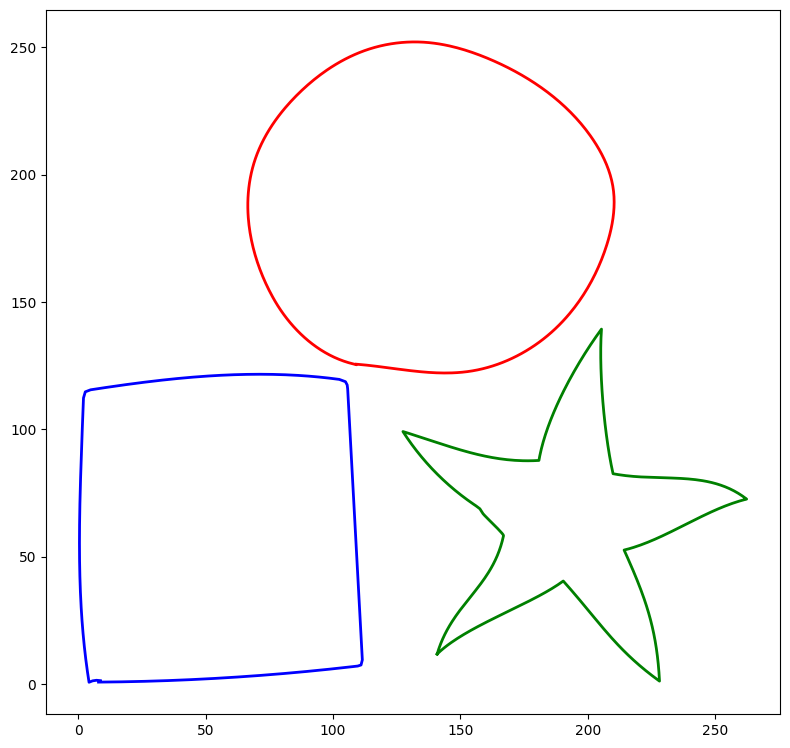

419
Compactness: 0.992289823063742, Hull Area: 14574.535798978466, Hull Perimeter: 429.6185540054191,Aspect Ratio: 1.0000295280301252, num_vertices: 397
Identified as circle
550
Compactness: 0.8633480837869744, Hull Area: 12747.868521835717, Hull Perimeter: 430.7554243917191,Aspect Ratio: 15532.58796759855, num_vertices: 6
identified as star
423
Compactness: 0.8290063799208852, Hull Area: 12521.755472778517, Hull Perimeter: 435.6709521916299,Aspect Ratio: 1.0000100048513283, num_vertices: 323
Identified as rectangle


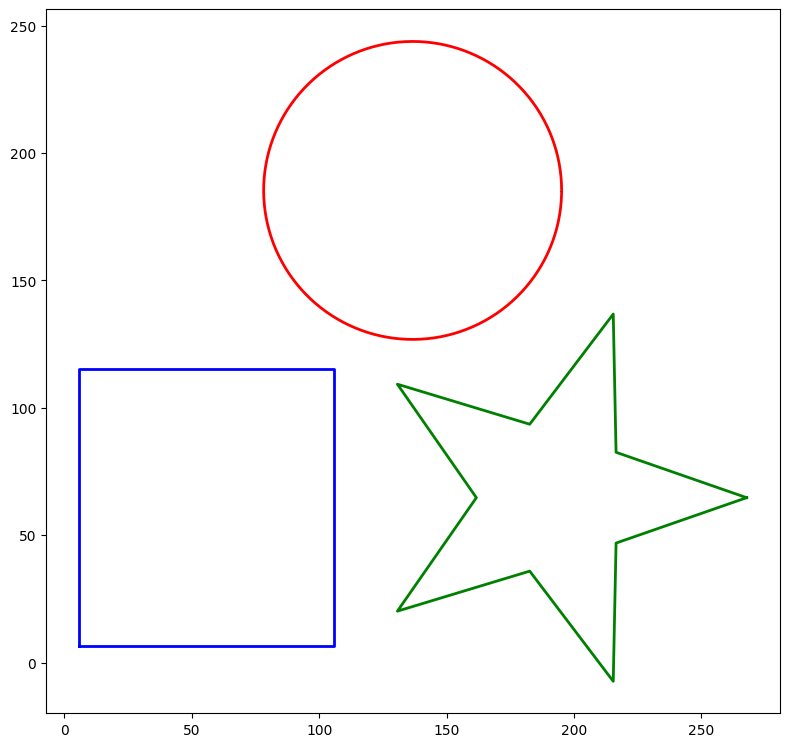

In [27]:
colours = ['r', 'g', 'b', 'y']
pathXY=read_csv('Test Dataset/isolated.csv')
regularized_path_XYs = []
plot(pathXY,colours)

for path in pathXY:
    regularized_path = []
    for shape in path:
        regularized_shape = regularize_shape(shape)
        regularized_path.append(regularized_shape)
    regularized_path_XYs.append(regularized_path)
plot(regularized_path_XYs, colours)